# Customer Personality Exploratory Analysis (With Poisson)

Group 25

TODO: names here

Hanson Sun

In [1]:
library(broom)
library(tidyverse)
library(ggplot2)
library(car)
library(leaps)
library(MASS)
library(dplyr)
library(corrplot)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


corrplot 0.92 loaded


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Introduction

The **Customer Personality Analysis** dataset contains **2,240 observations** and **29 variables**, providing demographic and behavioral insights into customer purchasing habits. It includes details such as age, income, marital status, and educational background, alongside purchasing behavior across different product categories (e.g., wine, meat, and sweets). Additionally, it tracks customer engagement through campaign responses, purchase channels (discount, store, web, catalog), and website visits.

An important characteristic of this dataset is its focus on **customer segmentation and targeted marketing** by analyzing spending patterns and campaign interactions. It also includes variables like customer complaints and recency of last purchase, which can help in understanding customer satisfaction and retention.

Below is a summary of the dataset's key variables:

| Variable Name            | Type    | Description                                                                |
|--------------------------|---------|----------------------------------------------------------------------------|
| **ID**                   | Integer | Unique identifier for each customer                                        |
| **Year_Birth**           | Integer | Year of birth of the customer                                              |
| **Education**            | Factor  | Educational qualification of the customer                                  |
| **Marital_Status**       | Factor  | Marital status of the customer                                             |
| **Income**               | Float   | Annual income of the customer                                              |
| **Kidhome**              | Integer | Number of children in the customer's household                             |
| **Teenhome**             | Integer | Number of teenagers in the customer's household                            |
| **Dt_Customer**          | Date    | Date of customer's enrollment with the company                             |
| **Recency**              | Integer | Number of days since the customer's last purchase                          |
| **Mnt`[item]`**            | Float   | Amount spent on `[item]` in the last two years (wine, fruits, meat, fish, sweets, gold)                               |
| **Num`[type]`**            | Integer | Number of `[type]` purchases (discount, web, catalog, store, web visits)                                |
| **AcceptedCmp1-5**       | Factor | 1 if customer accepted the offer in respective campaigns, 0 otherwise      |
| **Response**             | Factor | 1 if customer accepted the offer in the last campaign, 0 otherwise         |
| **Complain**             | Factor | 1 if customer complained in the last two years, 0 otherwise                |
| **Z_CostContact**        | Integer | Constant variable with value 3 (presumably cost related)                   |
| **Z_Revenue**            | Integer | Constant variable with value 11 (presumably revenue related)               |

### Source and Information 
Unfortunately, details regarding how the data is collected is not specified, but we know it is under CC0: Public Domain.

Data source: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis


### Research Question

**How is a person's family details and purchasing habits _associated_ with the number of web purchases they make?**
- **Response Variable**: `NumWebPurchases` (count of web purchases)
- **Explanatory Variables**: `Education`, `Marital_Status`, `Income`, `Kidhome`, `Teenhome`, `MntMeatProducts`, `NumStorePurchases`, `MntSweetProducts` + everything else that isn't dropped (more details [here](#Variable-Preselection))

This question focuses on **inference**, aiming to understand how personal and family details are associated with their number of web purchases. Specifically, we want to examine the relationships between `NumWebPurchases` and the explanatory variables to determine their significance. While there could be a predictive aspect, the primary goal is to analyze these relationships rather than make future predictions.

### Variable Preselection
The following variables will be dropped:
- `ID`: user ID holds no important information.
- `Z_Revenue` and `Z_CostContact`: their meaning is not specified in the data.
- `Response`, `AcceptedCmp1-5`, `Complain`, `Dt_Customer`, `Recency`: these are related to marketing campaigns, which deviates from our problem.

## Methods and Results

### Exploratory Data Analysis (EDA)

We will perform the following steps to help visualize and clean the data
1. remove redundant/unhelpful features
2. convert the data into the correct data types
3. Merge redundant levels and drop non-sensical observations
4. visualize the data via a faceted violin plot

We clean and display a section of the data below

In [2]:
# Main developer: Hanson
drop_variables <- c('ID', 'Z_CostContact', 'Z_Revenue', 'Response', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Dt_Customer', 'Recency')
data <- read.csv(url("https://raw.githubusercontent.com/Hanson-Sun/stat301-dataset/refs/heads/main/marketing_campaign.csv"), check.names = FALSE, stringsAsFactors=TRUE, sep="\t")

# remove redundant columns
data <- data %>% dplyr::select(-all_of(drop_variables))

# convert variables into correct types
data$Education <- as.factor(data$Education)
data$Marital_Status <- as.factor(data$Marital_Status)
data$Year_Birth <- as.integer(data$Year_Birth)
data$Income <- as.numeric(data$Income)
data$Kidhome <- as.integer(data$Kidhome)
data$Teenhome <- as.integer(data$Teenhome)
spending_vars <- c("MntWines", "MntFruits", "MntMeatProducts", 
                   "MntFishProducts", "MntSweetProducts", "MntGoldProds",
                   "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases",
                   "NumStorePurchases", "NumWebVisitsMonth")
data[spending_vars] <- lapply(data[spending_vars], as.numeric)

cat("\nUnique levels of Education:\n")
levels(data$Education)

cat("\nUnique levels of Marital Status:\n")
levels(data$Marital_Status)

cat("\nMissing data:\n")
colSums(is.na(data))



Unique levels of Education:


[1] "2n Cycle"   "Basic"      "Graduation" "Master"     "PhD"


Unique levels of Marital Status:


[1] "Absurd"   "Alone"    "Divorced" "Married"  "Single"   "Together" "Widow"   
[8] "YOLO"


Missing data:


Year_Birth           Education      Marital_Status              Income 
                  0                   0                   0                  24 
            Kidhome            Teenhome            MntWines           MntFruits 
                  0                   0                   0                   0 
    MntMeatProducts     MntFishProducts    MntSweetProducts        MntGoldProds 
                  0                   0                   0                   0 
  NumDealsPurchases     NumWebPurchases NumCatalogPurchases   NumStorePurchases 
                  0                   0                   0                   0 
  NumWebVisitsMonth 
                  0

#### Data Wrangling

There are some anomalies within our data:
- In `Marital_Status`, the levels `Absurd` and `YOLO` do not make sense, so we will drop those. Moreover, `Single` is the same as `Alone` and `Married` is the same as `Together` so they will be merged respectively. 
- In `Education`, `2n Cycle` is the European equivalent of a master's degree so it will be merged with `Master`
- 24 rows are missing `Income`; we will simply drop them instead of imputing any values. 

In [3]:
# Main developer: Hanson
# clean Marital_Status column
data <- data %>%
  mutate(Marital_Status = fct_recode(Marital_Status, "Single" = "Alone", "Married" = "Together")) %>% 
  filter(!Marital_Status %in% c("Absurd", "YOLO")) %>%
  droplevels()

# clean Education column
data <- data %>%
  mutate(Education = fct_recode(Education, "Master" = "2n Cycle")) %>%
  droplevels()

# remove rows with missing data
data <- na.omit(data)


#### Data Summary

Below we have the summary statistics of the cleaned data.

In [4]:
# Main developer: Hanson
cat("The cleaned dataset has", nrow(data), "rows and", ncol(data), "columns.\n")
head(data)
summary(data)

The cleaned dataset has 2212 rows and 17 columns.


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1957,Graduation,Single,58138,0,0,635,88,546,172,88,88,3,8,10,4,7
2,1954,Graduation,Single,46344,1,1,11,1,6,2,1,6,2,1,1,2,5
3,1965,Graduation,Married,71613,0,0,426,49,127,111,21,42,1,8,2,10,4
4,1984,Graduation,Married,26646,1,0,11,4,20,10,3,5,2,2,0,4,6
5,1981,PhD,Married,58293,1,0,173,43,118,46,27,15,5,5,3,6,5
6,1967,Master,Married,62513,0,1,520,42,98,0,42,14,2,6,4,10,6


   Year_Birth        Education     Marital_Status     Income      
 Min.   :1893   Master    : 564   Single  : 474   Min.   :  1730  
 1st Qu.:1959   Basic     :  54   Divorced: 232   1st Qu.: 35234  
 Median :1970   Graduation:1115   Married :1430   Median : 51382  
 Mean   :1969   PhD       : 479   Widow   :  76   Mean   : 52232  
 3rd Qu.:1977                                     3rd Qu.: 68522  
 Max.   :1996                                     Max.   :666666  
    Kidhome          Teenhome         MntWines         MntFruits     
 Min.   :0.0000   Min.   :0.0000   Min.   :   0.00   Min.   :  0.00  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:  23.75   1st Qu.:  1.75  
 Median :0.0000   Median :0.0000   Median : 173.50   Median :  8.00  
 Mean   :0.4426   Mean   :0.5054   Mean   : 305.03   Mean   : 26.32  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 505.50   3rd Qu.: 33.00  
 Max.   :2.0000   Max.   :2.0000   Max.   :1493.00   Max.   :199.00  
 MntMeatProducts  MntFishProducts  MntSwe

#### Data Visualization

We will visualize a subset of the features via a faceted violin plot. This visualization will specifically examine the family aspect and its impact on web purchases. Namely, how `Marital_Status` and family size (`Kidhome`, `Teenhome`) relate to web purchases (`NumWebPurchases`).

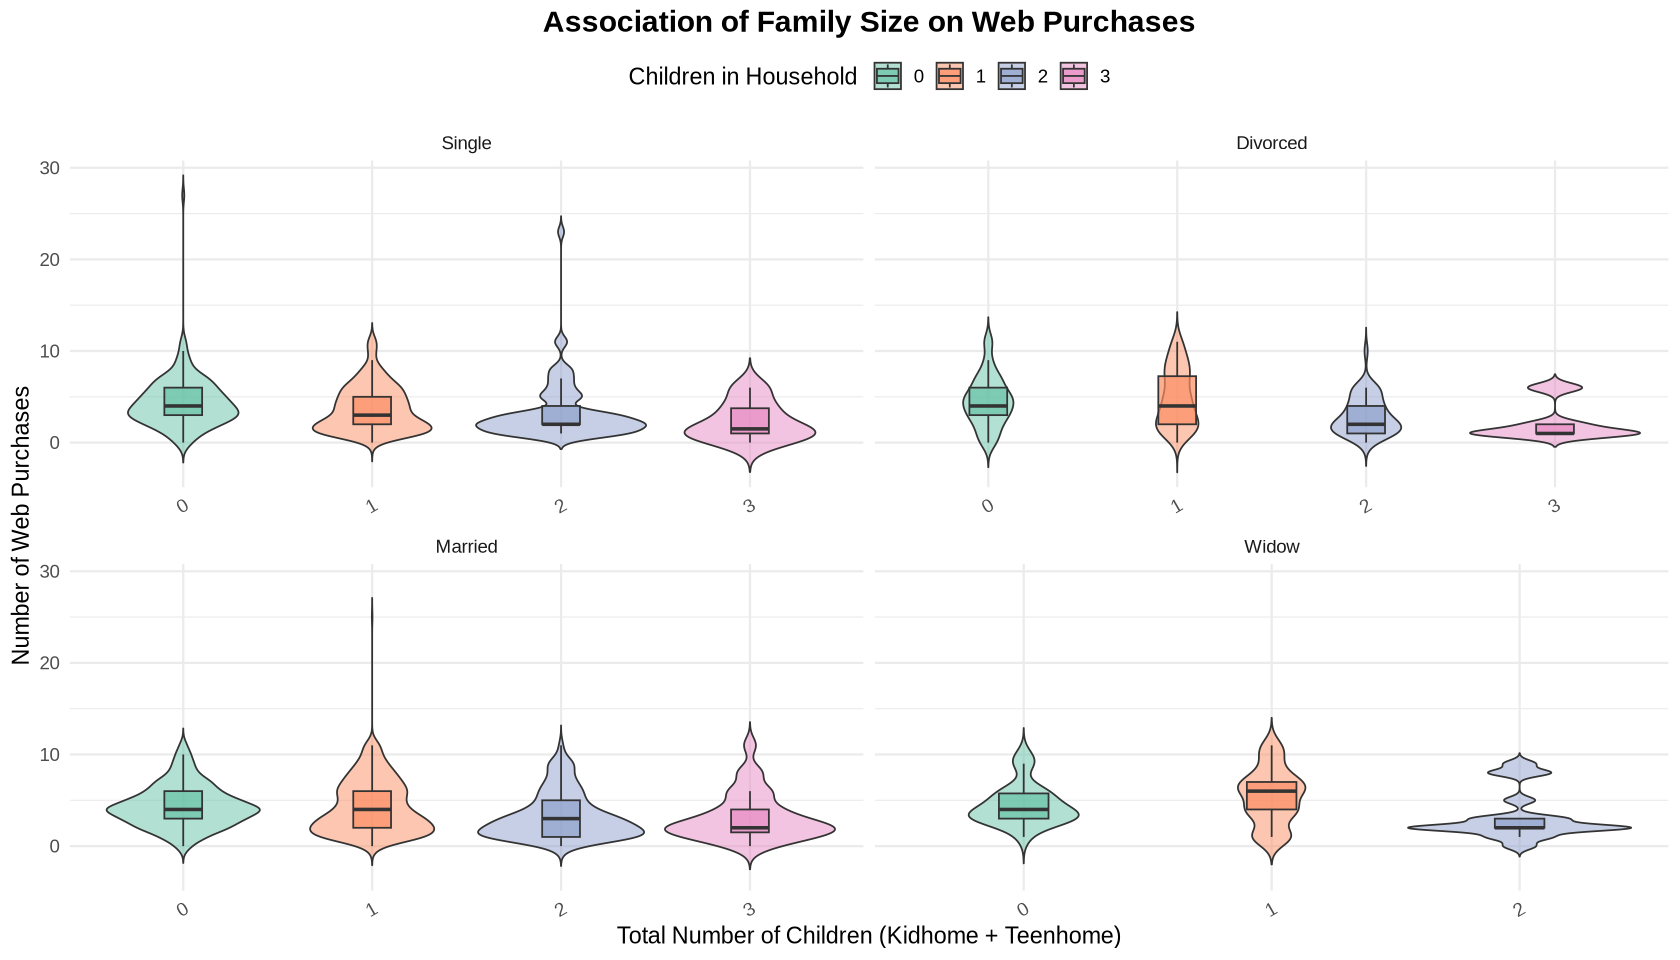

In [5]:
# Main developer: Hanson
options(repr.plot.width=14, repr.plot.height=8) 

ggplot(data, aes(x = as.factor(Kidhome + Teenhome), y = NumWebPurchases, fill = as.factor(Kidhome + Teenhome))) +
  geom_violin(alpha = 0.5, trim = FALSE) + 
  geom_boxplot(width = 0.2, outlier.shape = NA, alpha = 0.7) + 
  facet_wrap(~ Marital_Status, scales = "free_x") +
  scale_fill_brewer(palette = "Set2") +
  labs(title = "Association of Family Size on Web Purchases",
       x = "Total Number of Children (Kidhome + Teenhome)",
       y = "Number of Web Purchases",
       fill = "Children in Household") +
  theme_minimal(base_size = 14) + 
  theme(
    plot.title = element_text(face = "bold", size = 18, hjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1), 
    legend.position = "top" 
  )

The plot shows that family size (number of children) and marital status is **associated** with web purchases. Overall, individuals with **zero** children tend to have fewer web-based purchases, while those with **one or more** children exhibit a wider spread, suggesting more variability in purchasing behavior. The effect of marital status is also apparent -- **divorced and married** individuals tend to have more web purchases than **singles or widows**, though variability exists across groups. This insight helps build the Poisson regression model by confirming that family structure is a key predictor of web purchases, and perhaps an interaction of those terms can yield helpful results. We also notice a potential for overdispersion in some groups, as observed by the large variance in certain groups (perhaps using quasi models here will be a good idea). 

In [ ]:
      
# Main developer: Hanson
options(repr.plot.width=10, repr.plot.height=8)

# Select only numeric columns for correlation
numeric_data <- data %>% dplyr::select(where(is.numeric))

# Calculate correlation matrix
cor_matrix <- cor(numeric_data, use = "complete.obs")

# Create correlation plot
corrplot(cor_matrix, method = "color", type = "lower", 
         tl.col = "black", tl.srt = 45, tl.cex = 0.8, 
         addCoef.col = "black", number.cex = 0.6, # Add coefficients
         title = "Correlation Matrix of Numeric Variables", mar=c(0,0,1,0)) # Add title

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)

# Boxplot for Education
p1 <- ggplot(data, aes(x = Education, y = NumWebPurchases, fill = Education)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "NumWebPurchases by Education Level",
       x = "Education Level",
       y = "Number of Web Purchases") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = "none")

# Boxplot for Marital Status
p2 <- ggplot(data, aes(x = Marital_Status, y = NumWebPurchases, fill = Marital_Status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "NumWebPurchases by Marital Status",
       x = "Marital Status",
       y = "Number of Web Purchases") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1), legend.position = "none")

# Arrange plots 
grid.arrange(p1, p2, ncol = 2)

### Methods: Plan

We will focus on **inference** and the overview of the method is as follows:
1. split data into selection set and inference set
2. pick a Poisson model
3. perform step-wise forward selection (using BIC) on the selection set
4. train inference model and perform inference with `anova` and `z-test` ($\alpha = 0.05$)

Since our response variable is count-based, we will use a Poisson model. To determine useful covariates, we will use stepwise selection with BIC. We chose BIC since it favours simpler models (Occam's razor principle). Lastly, we use inference on our best model to determine the statistical significance of our predictors.

Here are the assumptions our method has:
- Variance of the response is equal to the mean
- The response variable is approximately linear
- Observations independent and identically distributed
- The true model is a subset of our available features (BIC assumption)

Here are some potential weaknesses:
- The variance of the response may not be equal to the mean, which would affect the effectiveness of the Poisson model
- Step-wise selection is based on a heuristic that may not lead to the optimal model.
- `anova` may suffer from inflated type-I error if there are too many predictors.
- The resulting predictors could be multicollinear, which will inflate $p$-values.


### Data Splitting
We will will perform a 60/40 split to get the selection and inference sets.

In [6]:
selection_data <- data %>% sample_frac(0.6)
inference_data <- data %>% setdiff(selection_data)

cat("selection set has ", nrow(selection_data), "rows and inference set has ", nrow(inference_data), "rows\n")

selection set has  1327 rows and inference set has  751 rows


### Step-wise Variable Selection
We will use `stepAIC` and the $\log$ approximation of `k` to get selection with BIC.

In [ ]:
full_model <- glm(NumWebPurchases ~ ., family = poisson, data = selection_data)
null_model <- glm(NumWebPurchases ~ 1, family = poisson, data = selection_data)
suppress_output <- capture.output(
  selected_model <- stepAIC(null_model, 
                            scope = list(lower = null_model, upper = full_model),
                            direction = "forward", 
                            k = log(nrow(selection_data))) # BIC
)

m_coefficients <- names(coef(selected_model))
m_coefficients <- m_coefficients[m_coefficients != "(Intercept)"]
cat("Deviance of the model:", selected_model$deviance, "Degrees of freedom:", selected_model$df.residual,  "\n")
vif(selected_model)

Deviance of the model: 791.0126 Degrees of freedom: 1318 


Teenhome   NumWebVisitsMonth     NumWebPurchases             Kidhome 
           1.101950            1.946261            1.819792            1.640691 
NumCatalogPurchases   NumStorePurchases              Income            MntWines 
           1.774020            2.383854            3.136413            3.060094

The VIF values are all less than 3, so multicollinearity is not a big problem with our predictors. Moreover, the deviance is close to the degrees of freedom, so we do not observe a significant amount of over-dispersion.

#### Inference and Final Results

We will perform our inference tests on the inference test and summarize the results in a table.

In [ ]:
inference_model <- glm(
  formula = as.formula(paste("NumWebPurchases ~", paste(m_coefficients, collapse = " + "))),
  family = poisson,
  data = inference_data
)
inference_null_model <- glm(NumWebPurchases ~ 1, family = poisson, data = inference_data)
anova_res <- anova(inference_null_model, inference_model, test = "Chisq")
coef_res <- coef(summary(inference_model))

anova_df <- as.data.frame(anova_res) %>% mutate(Type = "ANOVA")
coef_df <- as.data.frame(coef_res) %>% mutate(Type = "Coefficients", Term = rownames(.))
combined_results <- bind_rows(anova_df, coef_df, .id = "Source")
combined_results


,Source,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi),Type,Estimate,Std. Error,z value,Pr(>|z|),Term
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,750,1009.0176,NA,NA,NA,ANOVA,NA,NA,NA,NA,NA
2,1,742,544.9215,8,464.0961,3.52387e-95,ANOVA,NA,NA,NA,NA,NA
(Intercept),2,NA,NA,NA,NA,NA,Coefficients,-1.118087e+00,1.220205e-01,-9.1631089,5.042328e-20,(Intercept)
Teenhome,2,NA,NA,NA,NA,NA,Coefficients,5.198456e-01,4.203229e-02,12.3677694,3.905163e-35,Teenhome
NumWebVisitsMonth,2,NA,NA,NA,NA,NA,Coefficients,1.401468e-01,1.092341e-02,12.8299476,1.114395e-37,NumWebVisitsMonth
NumWebPurchases,2,NA,NA,NA,NA,NA,Coefficients,4.441393e-02,9.801192e-03,4.5314827,5.857113e-06,NumWebPurchases
Kidhome,2,NA,NA,NA,NA,NA,Coefficients,4.261203e-01,5.111552e-02,8.3364185,7.657457e-17,Kidhome
NumCatalogPurchases,2,NA,NA,NA,NA,NA,Coefficients,8.033190e-02,1.214536e-02,6.6142055,3.735525e-11,NumCatalogPurchases
NumStorePurchases,2,NA,NA,NA,NA,NA,Coefficients,5.799635e-02,1.126306e-02,5.1492539,2.615246e-07,NumStorePurchases


## Discussion
In our ANOVA test, the $p$-value is less than $0.05$, which provides sufficient evidence to conclude that our final model significantly different from the null model. 
Similarly, from the $z$-test, all $p$-values are well below $0.05$, indicating that the coefficients for our selected covariates are statistically significant. 
The results are somewhat expected, as the selected covariates are all intuitively relevant to the problem (surprisingly `Salary` and `Marital Status` were not selected). 
In conclusion, we can say that `Teenhome`, `Kidhome`, `NumWebVisitsMonth`, `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `MntWines`, `MntFruits` are **associated** with the number of discount purchases a person makes.



## References
TODO...